In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from fbprophet import Prophet
from datetime import datetime

#### Read in oil data from csv

In [2]:
df_oil = pd.read_csv('brent_continuous.csv')

In [3]:
df_oil.head()

Date   Open   High    Low  Settle  Change   Wave    Volume  \
0  2019-05-31  66.24  66.28  64.37   64.49   -2.38  65.01   18048.0   
1  2019-05-30  69.68  69.96  66.31   66.87   -2.58  68.13   97325.0   
2  2019-05-29  70.10  70.10  68.08   69.45   -0.66  68.96  138447.0   
3  2019-05-28  69.99  70.59  69.58   70.11    0.00  70.04  229587.0   
4  2019-05-27  69.15  70.23  68.53   70.11    1.42  69.22   71979.0   

   Prev. Day Open Interest  EFP Volume  EFS Volume  Block Volume  
0                  57133.0      3600.0         NaN         100.0  
1                 112444.0      6600.0         NaN        1346.0  
2                 144605.0      7407.0        17.0        2604.0  
3                 192343.0        12.0        17.0        9265.0  
4                 199176.0         NaN         NaN         200.0

### Rename the columns, prophet needs the columns to be explicit

In [4]:
df_oil.rename(columns={'Date': 'ds', 'Change': 'y'}, inplace=True)

In [5]:
df_oil.ds = pd.to_datetime(df_oil.ds, format="%Y-%m-%d")

In [6]:
df_oil.tail()

ds   Open   High    Low  Settle   y  Wave  Volume  \
6680 1993-03-23  18.61  18.61  18.61   18.61 NaN   NaN     0.0   
6681 1993-03-22  18.50  18.50  18.50   18.50 NaN   NaN     0.0   
6682 1993-03-19  18.89  18.89  18.89   18.89 NaN   NaN     0.0   
6683 1993-03-18  18.87  18.87  18.87   18.87 NaN   NaN     0.0   
6684 1993-03-17  18.80  18.80  18.80   18.80 NaN   NaN     0.0   

      Prev. Day Open Interest  EFP Volume  EFS Volume  Block Volume  
6680                      0.0         NaN         NaN           NaN  
6681                      0.0         NaN         NaN           NaN  
6682                      0.0         NaN         NaN           NaN  
6683                      0.0         NaN         NaN           NaN  
6684                      0.0         NaN         NaN           NaN

In [7]:
df_oil.describe()

Open         High          Low       Settle            y  \
count  6624.000000  6624.000000  6624.000000  6624.000000  3953.000000   
mean     52.784565    53.453759    52.086591    52.787406     0.003838   
std      33.541544    33.900409    33.152659    33.553543     1.409154   
min       9.700000     9.950000     9.550000     9.640000   -10.390000   
25%      22.400000    22.715000    22.060000    22.340000    -0.720000   
50%      48.250000    49.110000    47.470000    48.265000     0.050000   
75%      74.692500    75.585000    73.680000    74.652500     0.760000   
max     146.300000   147.500000   144.250000   146.080000    10.150000   

             Wave         Volume  Prev. Day Open Interest    EFP Volume  \
count  919.000000    6632.000000              6684.000000   3712.000000   
mean    57.636366  100256.833233            138912.333034   2113.271821   
std     12.549694  100065.736132            129797.099289   2167.257953   
min     27.860000       0.000000                 0.000000      0.000000   
25%     48.600000   22540.500000             58035.000000    917.000000   
50%     55.770000   52303.500000             84114.000000   1753.000000   
75%     67.970000  170077.250000            190441.000000   2645.000000   
max     85.440000  745954.000000            676659.000000  25088.000000   

       EFS Volume  Block Volume  
count  2647.00000   3908.000000  
mean   1141.90782   3693.160440  
std    1198.09408   3941.138488  
min       0.00000      0.000000  
25%      93.00000    900.000000  
50%     851.00000   2638.500000  
75%    1757.00000   5328.500000  
max    7491.00000  41402.000000

## Using Prophet

#### import some functions help with graphing and plots

In [8]:
import utils_prophet

In [9]:
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

#### Ignore the pystan DeprecatingWarning

In [10]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

In [11]:
import os
import sys
from glob import glob
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as RMSE
from scipy.stats import skew
from calendar import day_abbr, month_abbr, mdays
import holidays
import fbprophet
from fbprophet.plot import add_changepoints_to_plot

#### Creat test and train sets 

In [12]:
df_train = df_oil[['ds','y']]

In [13]:
mask = (df_train['ds'] >= '2018-01-01') & (df_train['ds'] < '2019-03-01')

In [14]:
df_train = df_train.loc[mask]

In [15]:
df_test = df_oil[['ds','y']]

In [16]:
df_test = df_test[df_test['ds'] >= '2019-03-01']

In [17]:
df_train.isnull().sum()

ds    0
y     4
dtype: int64

In [18]:
df_test.isnull().sum()

ds    0
y     1
dtype: int64

In [19]:
df_train = df_train.sort_values(by='ds',ascending=True)

In [20]:
df_train.reset_index(drop=True, inplace=True)

In [21]:
df_train.fillna(method="ffill", inplace=True)

In [22]:
df_test.fillna(method='ffill', inplace=True)

In [23]:
df_test.isnull().sum()

ds    0
y     0
dtype: int64

In [24]:
df_train.dropna(inplace=True)

In [25]:
df_train.isnull().sum()

ds    0
y     0
dtype: int64

In [26]:
df_test = df_test.sort_values(by='ds', ascending=True)

In [27]:
df_test.reset_index(drop=True, inplace=True)

In [28]:
df_test.head()

ds     y
0 2019-03-01 -1.24
1 2019-03-04  0.60
2 2019-03-05  0.19
3 2019-03-06  0.13
4 2019-03-07  0.31

In [29]:
df_train.tail()

ds     y
295 2019-02-22  0.05
296 2019-02-25 -2.36
297 2019-02-26  0.45
298 2019-02-27  1.18
299 2019-02-28 -0.27

#### Instantiate and fit prophet model to the training set

In [30]:
m=Prophet(changepoint_prior_scale=.005, daily_seasonality=False, yearly_seasonality=True, \
            weekly_seasonality=True, mcmc_samples=75, seasonality_prior_scale=100)

In [31]:
m.fit(df_train)

#### Make future dataframe

In [32]:
future = m.make_future_dataframe(periods=len(df_test), freq='B')
future.tail()

ds
359 2019-05-24
360 2019-05-27
361 2019-05-28
362 2019-05-29
363 2019-05-30

In [33]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
359 2019-05-24  0.075229   -1.688810    1.646221
360 2019-05-27 -0.094905   -1.811937    1.653859
361 2019-05-28 -0.252958   -1.934066    1.388454
362 2019-05-29  0.042300   -1.671912    1.824154
363 2019-05-30 -0.302382   -1.937899    1.364496

In [34]:
forecast.head(5)

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-01-03 -0.053767   -1.781275    1.612421    -1.071840     1.248981   
1 2018-01-04 -0.053307   -1.948617    1.326174    -1.070687     1.248725   
2 2018-01-05 -0.052847   -1.439680    1.690671    -1.069534     1.248469   
3 2018-01-08 -0.051465   -1.314901    1.873846    -1.066075     1.247701   
4 2018-01-09 -0.051005   -1.462022    1.794905    -1.064923     1.247445   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0       -0.024542             -1.375979              0.954150  0.065202   
1       -0.267881             -1.629136              0.895113 -0.289267   
2        0.193670             -1.027690              1.227304  0.066511   
3        0.325679             -0.975931              1.400762 -0.067410   
4        0.234184             -1.045578              1.292895 -0.225100   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -1.187769      1.085536 -0.089744     -0.424610      0.266452   
1     -1.589455      0.741170  0.021386     -0.298601      0.354139   
2     -1.219444      1.037675  0.127159     -0.176576      0.433680   
3     -1.513824      0.888618  0.393090      0.104615      0.657683   
4     -1.467260      0.757560  0.459285      0.168091      0.721134   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper      yhat  
0                         0.0 -0.078309  
1                         0.0 -0.321188  
2                         0.0  0.140823  
3                         0.0  0.274214  
4                         0.0  0.183180

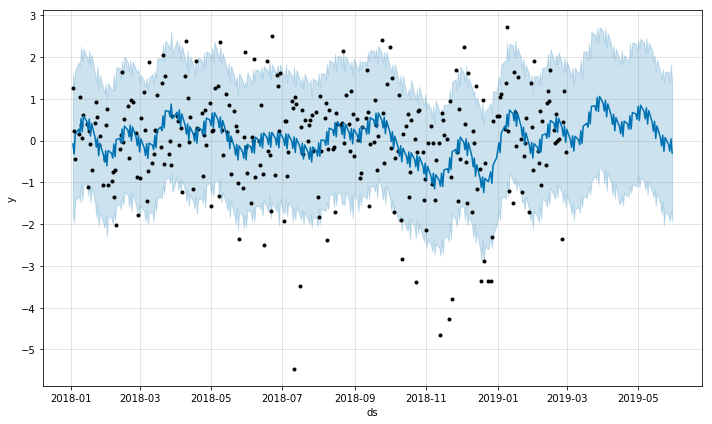

In [35]:
fig = m.plot(forecast)
#a = add_changepoints_to_plot(fig.gca(), m, forecast)

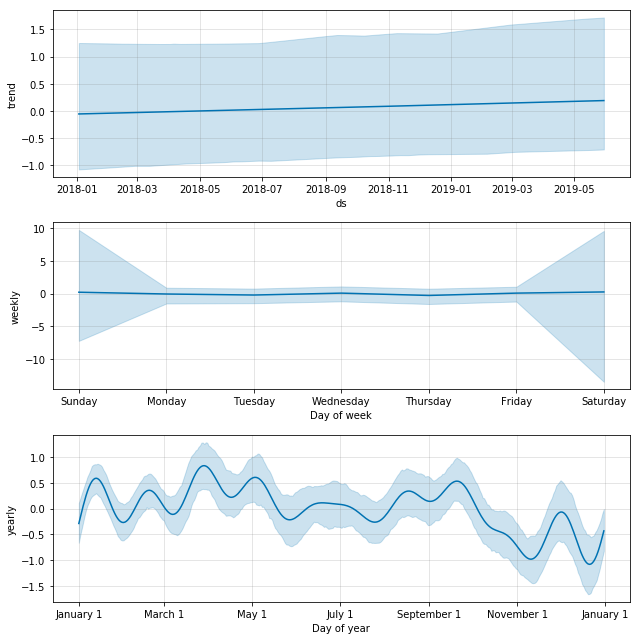

In [36]:
f = m.plot_components(forecast)

In [37]:
data  = pd.concat([df_train, df_test], axis=0)

In [38]:
forecast.index = forecast.ds

In [39]:
data.index = data.ds

In [40]:
forecast['y'] = data.y.values

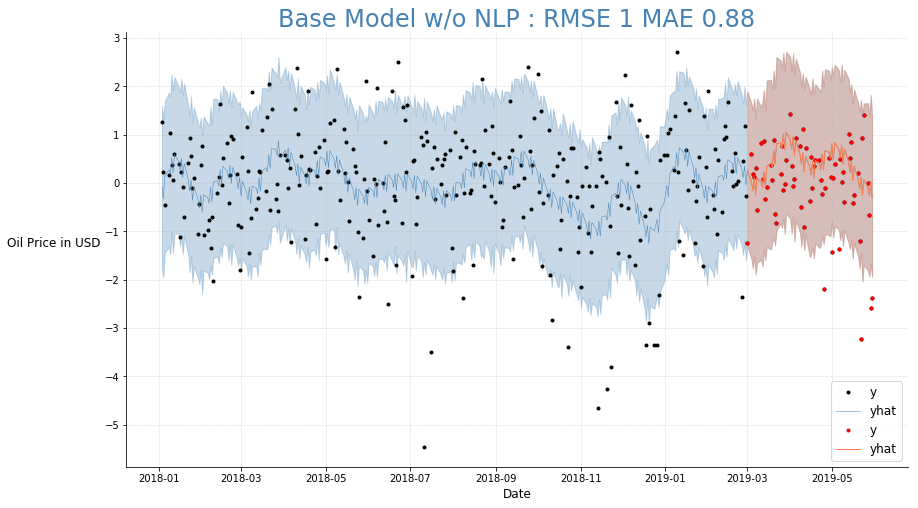

In [460]:
f, ax = plt.subplots(figsize=(14, 8))
ax.plot(forecast.index, forecast.y, 'ko', markersize=3)
ax.plot(forecast.index, forecast.yhat, color='steelblue', lw=0.5)
ax.fill_between(forecast.index, forecast.yhat_lower, forecast.yhat_upper, color='steelblue', alpha=0.3)
test = forecast.loc['2019-03-01':'2019-06-02']
ax.plot(test.index, test.y, 'ro', markersize=3)
ax.plot(test.index, test.yhat, color='coral', lw=1)
ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
ax.grid(ls=':', lw=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='lower right', fontsize=12)
plt.title("Base Model w/o NLP : RMSE 1 MAE 0.88", color='steelblue', size=24)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Oil Price in USD", fontsize=12,rotation='horizontal',ha='right');

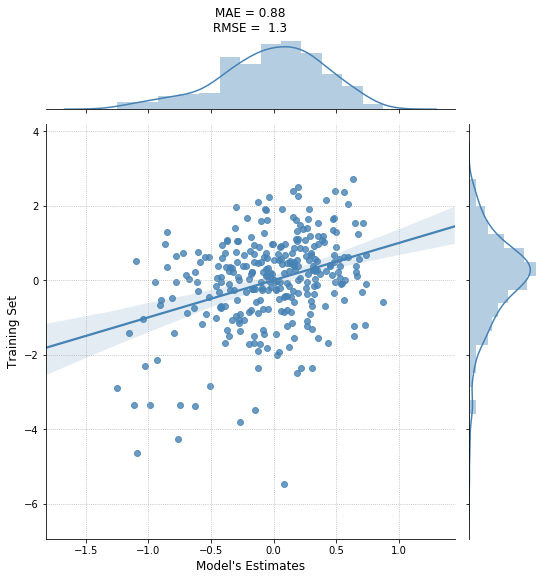

In [42]:
train = forecast.loc['2018-01-01':'2019-03-01']
g = sns.jointplot(x='yhat', y='y', data = train, kind="reg", color="steelblue")
g.fig.set_figwidth(8)
g.fig.set_figheight(8)
ax = g.fig.axes[1]
ax.set_title("MAE = {:4.2f}\nRMSE = {:4.1f}".format(MAE(train.loc[:,'y'].values, train.loc[:,'yhat'].values), RMSE(train.loc[:,'y'].values, train.loc[:,'yhat'].values)), fontsize=12)
ax = g.fig.axes[0]
ax.set_xlabel("Model's Estimates", fontsize=12)
ax.set_ylabel("Training Set", fontsize=12)
ax.grid(ls=':')


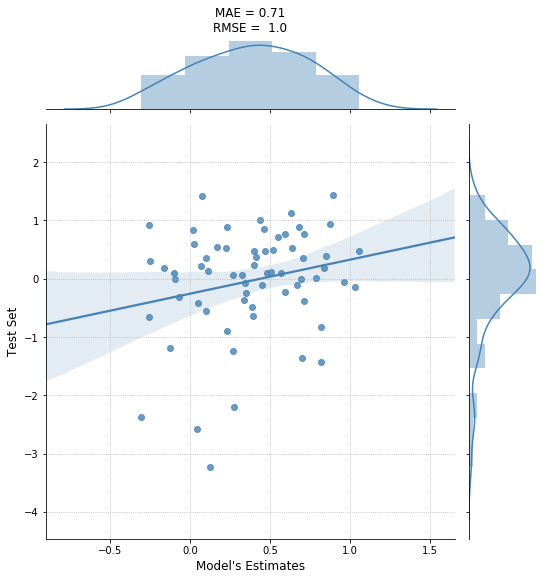

In [43]:
test = forecast.loc['2019-03-01':'2019-06-02']
g = sns.jointplot(x='yhat', y='y', data = test, kind="reg", color="steelblue")
g.fig.set_figwidth(8)
g.fig.set_figheight(8)
ax = g.fig.axes[1]
ax.set_title("MAE = {:4.2f}\nRMSE = {:4.1f}".format(MAE(test.loc[:,'y'].values, test.loc[:,'yhat'].values), RMSE(test.loc[:,'y'].values, test.loc[:,'yhat'].values)), fontsize=12)
ax = g.fig.axes[0]
ax.set_xlabel("Model's Estimates", fontsize=12)
ax.set_ylabel("Test Set", fontsize=12)
ax.grid(ls=':')

#### Add regressors to the model, incorporating NLP topics

In [567]:
mask = (df_oil['ds'] >= '2018-01-01') & (df_oil['ds'] <= '2019-05-30')

In [568]:
df_nlp = df_oil.loc[mask]

In [569]:
df_nlp.index = df_nlp['ds']

In [570]:
df_nlp = df_nlp[['ds','y']]

In [571]:
df_topic_sentiment = pd.read_pickle('ts_topic_sentiment.pkl')

In [572]:
df_topic_sentiment.index

Index([2017-11-27, 2017-11-28, 2017-11-29, 2017-11-30, 2017-12-01, 2017-12-04,
       2017-12-05, 2017-12-06, 2017-12-07, 2017-12-08,
       ...
       2019-05-18, 2019-05-19, 2019-05-20, 2019-05-21, 2019-05-22, 2019-05-23,
       2019-05-24, 2019-05-28, 2019-05-29, 2019-05-30],
      dtype='object', name='day', length=391)

In [573]:
df_topic_sentiment.index = pd.to_datetime(df_topic_sentiment.index, format="%Y-%m-%d")

In [574]:
df_topic_sentiment = df_topic_sentiment.loc['2018-01-01':'2019-05-30']

In [575]:
df_topic_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 370 entries, 2018-01-02 to 2019-05-30
Data columns (total 7 columns):
OPEC              370 non-null float64
Weekly_Stats      370 non-null float64
Iran_Sanctions    370 non-null float64
Agency_Stats      370 non-null float64
CFTC              370 non-null float64
Demand            370 non-null float64
Trade             370 non-null float64
dtypes: float64(7)
memory usage: 23.1 KB


In [576]:
df_combined = pd.merge(df_nlp, df_topic_sentiment, how='inner', left_index=True, right_index=True)

In [577]:
df_combined.sort_values(by="ds", inplace=True)

In [578]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354 entries, 2018-01-02 to 2019-05-30
Data columns (total 9 columns):
ds                354 non-null datetime64[ns]
y                 350 non-null float64
OPEC              354 non-null float64
Weekly_Stats      354 non-null float64
Iran_Sanctions    354 non-null float64
Agency_Stats      354 non-null float64
CFTC              354 non-null float64
Demand            354 non-null float64
Trade             354 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 27.7 KB


In [579]:
df_combined.fillna(method='ffill', inplace=True)

In [580]:
df_combined.to_csv('ts_topic_sentiment.csv')

In [581]:
corr = df_combined.corr()

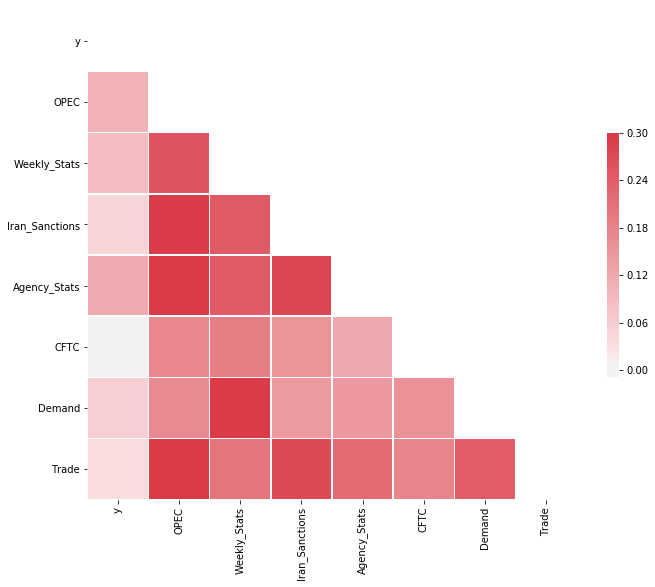

In [582]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

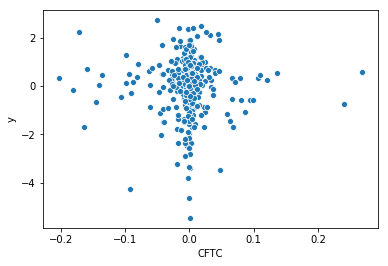

In [583]:
sns.scatterplot(x='CFTC',y='y', data=df_combined)

#### Create Train and Test Set

In [584]:
df_test_nlp = df_combined[df_combined['ds'] >= '2019-03-01']

In [585]:
df_test_nlp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63 entries, 2019-03-01 to 2019-05-30
Data columns (total 9 columns):
ds                63 non-null datetime64[ns]
y                 63 non-null float64
OPEC              63 non-null float64
Weekly_Stats      63 non-null float64
Iran_Sanctions    63 non-null float64
Agency_Stats      63 non-null float64
CFTC              63 non-null float64
Demand            63 non-null float64
Trade             63 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 4.9 KB


In [586]:
mask_train = (df_combined['ds'] >= '2018-01-01') & (df_combined['ds'] < '2019-03-01')

In [587]:
df_train_nlp = df_combined.loc[mask_train]

#### Instantiate a new fbprophet model with the same parameters as before

In [628]:
m=Prophet(changepoint_prior_scale=.005, daily_seasonality=False, yearly_seasonality=True, \
            weekly_seasonality=True, mcmc_samples=75, seasonality_prior_scale=100)

##### Add the NLP topics as regressors

In [629]:
m.add_regressor('OPEC', prior_scale= 1, standardize=False, mode='multiplicative')
m.add_regressor('Weekly_Stats', prior_scale=.1, standardize=False, mode='multiplicative')
m.add_regressor('Iran_Sanctions', prior_scale=1, standardize=False, mode='multiplicative')
m.add_regressor('Agency_Stats', prior_scale=.1, standardize=False, mode='multiplicative')
m.add_regressor('CFTC', prior_scale=.1, standardize=False, mode='multiplicative')
m.add_regressor('Demand', prior_scale=1, standardize=False, mode='multiplicative')
m.add_regressor('Trade', prior_scale=1, standardize=False, mode='multiplicative')

In [630]:
# m.add_regressor('OPEC', prior_scale=1, standardize=False, mode='multiplicative')
# m.add_regressor('Weekly_Stats', prior_scale=1, standardize=False, mode='multiplicative')
# m.add_regressor('Iran_Sanctions', prior_scale=1, standardize=False, mode='multiplicative')
# m.add_regressor('Agency_Stats', prior_scale=1, standardize=False, mode='multiplicative')
# m.add_regressor('CFTC', prior_scale=1, standardize=False, mode='multiplicative')
# m.add_regressor('Demand', prior_scale=1, standardize=False, mode='multiplicative')
# m.add_regressor('Trade', prior_scale=1, standardize=False, mode='multiplicative')

In [631]:
m.fit(df_train_nlp)

In [632]:
future = m.make_future_dataframe(periods=len(df_test_nlp), freq='B')

##### Need to add regressors to the futures dataframe

In [633]:
future = future.merge(df_combined, left_on='ds', right_on='ds', how='inner')

In [634]:
future.drop(columns='y', inplace=True)

In [635]:
future.tail()

ds      OPEC  Weekly_Stats  Iran_Sanctions  Agency_Stats  \
347 2019-05-21  0.199294      0.164100        0.169110      0.169150   
348 2019-05-22 -0.063758     -0.071647       -0.083995     -0.027242   
349 2019-05-23 -0.251120     -0.116478       -0.138150     -0.038807   
350 2019-05-24 -0.008423     -0.220635       -0.261046     -0.044769   
351 2019-05-28  0.010986     -0.026668       -0.019592     -0.018662   

         CFTC    Demand     Trade  
347  0.007275 -0.020215  0.271286  
348 -0.018333 -0.100123 -0.168235  
349 -0.019960 -0.067132 -0.468353  
350 -0.080378 -0.068362 -0.041387  
351 -0.025964 -0.030589 -0.016654

In [636]:
forecast_nlp = m.predict(future)

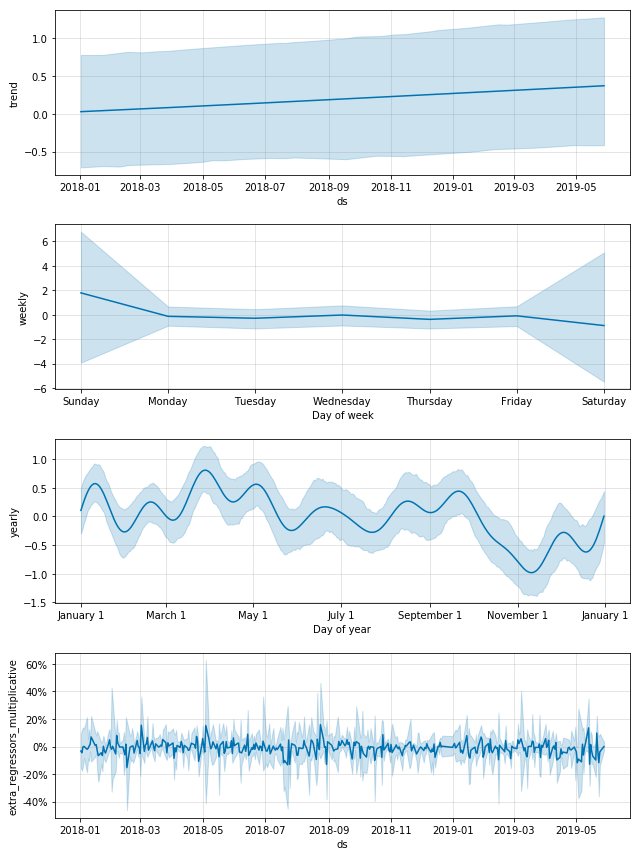

In [637]:
f = m.plot_components(forecast_nlp)

In [638]:
data_nlp = pd.concat([df_train_nlp, df_test_nlp], axis=0)

In [639]:
forecast_nlp.index = forecast_nlp.ds

In [640]:
data_nlp.index = data_nlp.ds

In [641]:
data_y = data_nlp['y']

In [642]:
data_y.index = data_nlp.index

In [643]:
forecast_nlp = forecast_nlp.merge(data_y, left_index=True, right_index=True, how='inner')

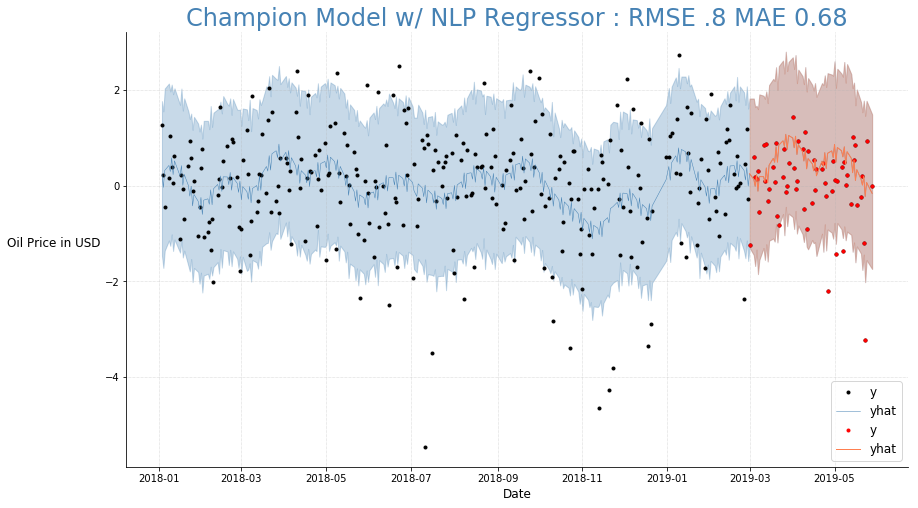

In [647]:
f, ax = plt.subplots(figsize=(14, 8))
ax.plot(forecast_nlp.index, forecast_nlp.y, 'ko', markersize=3)
ax.plot(forecast_nlp.index, forecast_nlp.yhat, color='steelblue', lw=0.5)
ax.fill_between(forecast_nlp.index, forecast_nlp.yhat_lower, forecast_nlp.yhat_upper, color='steelblue', alpha=0.3)
test = forecast_nlp.loc['2019-03-01':'2019-05-30']
ax.plot(test.index, test.y, 'ro', markersize=3)
ax.plot(test.index, test.yhat, color='coral', lw=1)
ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
ax.grid(ls=':', lw=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='lower right', fontsize=12)
plt.title("Champion Model w/ NLP Regressor : RMSE .8 MAE 0.68", color='steelblue', size=24)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Oil Price in USD", fontsize=12,rotation='horizontal',ha='right');

In [645]:
forecast_nlp.dropna(inplace=True)

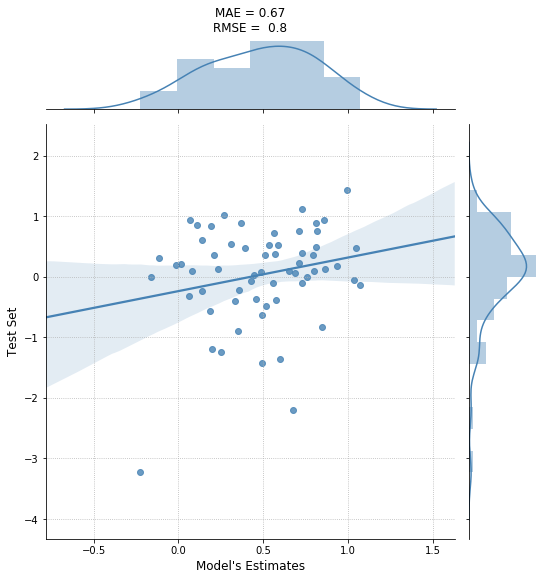

In [646]:
test = forecast_nlp.loc['2019-03-01':'2019-06-02']
g = sns.jointplot(x='yhat', y='y', data = test, kind="reg", color="steelblue")
g.fig.set_figwidth(8)
g.fig.set_figheight(8)
ax = g.fig.axes[1]
ax.set_title("MAE = {:4.2f}\nRMSE = {:4.1f}".format(MAE(test.loc[:,'y'].values, test.loc[:,'yhat'].values), RMSE(test.loc[:,'y'].values, test.loc[:,'yhat'].values)), fontsize=12)
ax = g.fig.axes[0]
ax.set_xlabel("Model's Estimates", fontsize=12)
ax.set_ylabel("Test Set", fontsize=12)
ax.grid(ls=':')

In [607]:
forecast_nlp.tail()

ds     trend  yhat_lower  yhat_upper  trend_lower  \
ds                                                                     
2019-05-21 2019-05-21  1.223762   -1.609947    1.597061     0.422110   
2019-05-22 2019-05-22  1.224361   -1.386378    1.995258     0.421939   
2019-05-23 2019-05-23  1.224960   -1.919519    1.610095     0.421797   
2019-05-24 2019-05-24  1.225559   -1.618484    1.756259     0.421654   
2019-05-28 2019-05-28  1.227955   -1.827099    1.416334     0.421084   

            trend_upper  Agency_Stats  Agency_Stats_lower  Agency_Stats_upper  \
ds                                                                              
2019-05-21     2.290331     -0.001292           -0.019021            0.018124   
2019-05-22     2.290228      0.000208           -0.002919            0.003063   
2019-05-23     2.290251      0.000296           -0.004158            0.004364   
2019-05-24     2.291529      0.000342           -0.004797            0.005034   
2019-05-28     2.294399      0.000143           -0.002000            0.002098   

                CFTC  ...  multiplicative_terms_lower  \
ds                    ...                               
2019-05-21  0.000351  ...                   -0.144190   
2019-05-22 -0.000884  ...                   -0.164364   
2019-05-23 -0.000962  ...                   -0.231377   
2019-05-24 -0.003875  ...                   -0.224403   
2019-05-28 -0.001252  ...                   -0.039214   

            multiplicative_terms_upper    weekly  weekly_lower  weekly_upper  \
ds                                                                             
2019-05-21                    0.146230 -1.188808     -2.500391     -0.498354   
2019-05-22                    0.086680 -0.906024     -2.069469     -0.179582   
2019-05-23                    0.293110 -1.232010     -2.459498     -0.433070   
2019-05-24                    0.105491 -0.926782     -2.236790     -0.138788   
2019-05-28                    0.012964 -1.188808     -2.500391     -0.498354   

              yearly  yearly_lower  yearly_upper      yhat     y  
ds                                                                
2019-05-21 -0.056166     -0.470964      0.392408 -0.042260  0.21  
2019-05-22 -0.094348     -0.538462      0.389117  0.188157 -1.19  
2019-05-23 -0.127879     -0.605651      0.334499 -0.108817 -3.23  
2019-05-24 -0.156388     -0.635807      0.295555  0.071932  0.93  
2019-05-28 -0.217042     -0.673693      0.218183 -0.190183  0.00  

[5 rows x 44 columns]

In [608]:
value = df_oil[df_oil['ds']=='2018-01-02']

In [609]:
value.Settle.values

array([66.57])

In [610]:
df_cumsum = forecast_nlp.loc['2019-03-01':'2019-05-28']

In [611]:
df_cumsum['cumsum'] = df_cumsum['y'].cumsum()

/Users/robfang29/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [612]:
df_cumsum['jumpoff'] = 66.31

/Users/robfang29/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [613]:
df_cumsum['yhat'] = df_cumsum['cumsum'] + df_cumsum['jumpoff']

/Users/robfang29/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



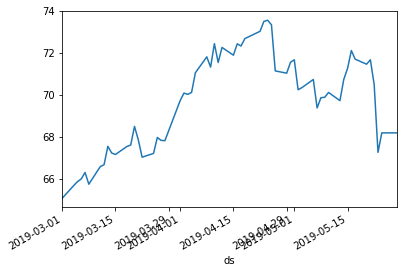

In [614]:
df_cumsum['yhat'].plot()

In [615]:
df_cumsum['yhat_lower_abs'] = round(df_cumsum['yhat_lower'] + df_cumsum['yhat'])

/Users/robfang29/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [616]:
df_cumsum['yhat_upper_abs'] = round(df_cumsum['yhat_upper'] + df_cumsum['yhat'])

/Users/robfang29/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [617]:
df_cumsum.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  \
ds                                                                     
2019-03-01 2019-03-01  1.175241   -1.285541    1.886309     0.433269   
2019-03-04 2019-03-04  1.177038   -1.577145    1.749346     0.434659   
2019-03-05 2019-03-05  1.177637   -1.880211    1.421762     0.435125   
2019-03-06 2019-03-06  1.178236   -1.497753    1.777209     0.435566   
2019-03-07 2019-03-07  1.178835   -1.915149    1.574708     0.435963   

            trend_upper  Agency_Stats  Agency_Stats_lower  Agency_Stats_upper  \
ds                                                                              
2019-03-01     2.280262      0.000045           -0.000631            0.000662   
2019-03-04     2.280491      0.000002           -0.000032            0.000034   
2019-03-05     2.280567     -0.000025           -0.000371            0.000353   
2019-03-06     2.280643     -0.000016           -0.000232            0.000221   
2019-03-07     2.280719      0.000033           -0.000456            0.000479   

                CFTC  ...  weekly_upper    yearly  yearly_lower  yearly_upper  \
ds                    ...                                                       
2019-03-01 -0.000115  ...     -0.138788 -0.014237     -0.403950      0.359509   
2019-03-04  0.002214  ...     -0.245411 -0.076589     -0.509783      0.374146   
2019-03-05  0.000077  ...     -0.498354 -0.086183     -0.507791      0.397424   
2019-03-06 -0.000145  ...     -0.179582 -0.088916     -0.503576      0.413663   
2019-03-07  0.000123  ...     -0.433070 -0.084294     -0.498796      0.419743   

             yhat     y  cumsum  jumpoff  yhat_lower_abs  yhat_upper_abs  
ds                                                                        
2019-03-01  65.07 -1.24   -1.24    66.31            64.0            67.0  
2019-03-04  65.67  0.60   -0.64    66.31            64.0            67.0  
2019-03-05  65.86  0.19   -0.45    66.31            64.0            67.0  
2019-03-06  65.99  0.13   -0.32    66.31            64.0            68.0  
2019-03-07  66.30  0.31   -0.01    66.31            64.0            68.0  

[5 rows x 48 columns]

In [618]:
forecast_nlp_abs = pd.read_pickle('pred_y.pkl')

In [619]:
forecast_nlp_abs.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
ds                                                                      
2019-05-24 2019-05-24  67.828080   70.730314   77.873385    55.278137   
2019-05-27 2019-05-27  67.809064   70.120997   77.352991    55.281774   
2019-05-28 2019-05-28  67.802726   70.158365   77.101285    55.282987   
2019-05-29 2019-05-29  67.796388   70.205123   77.109093    55.283704   
2019-05-30 2019-05-30  67.790049   69.413125   76.835431    55.288342   

            trend_upper  additive_terms  additive_terms_lower  \
ds                                                              
2019-05-24    77.400127        6.538767             -2.323232   
2019-05-27    77.393257        5.976404             -2.841146   
2019-05-28    77.390968        5.967572             -2.542096   
2019-05-29    77.388678        5.907683             -2.868696   
2019-05-30    77.386388        5.530962             -2.674203   

            additive_terms_upper    weekly  weekly_lower  weekly_upper  \
ds                                                                       
2019-05-24             20.213716  0.615871     -8.431590     14.445670   
2019-05-27             19.756326  0.487352     -8.667285     14.395254   
2019-05-28             19.925398  0.630036     -8.263688     14.719029   
2019-05-29             19.525631  0.720206     -8.500771     14.327058   
2019-05-30             19.193253  0.489470     -8.205249     14.081417   

              yearly  yearly_lower  yearly_upper  multiplicative_terms  \
ds                                                                       
2019-05-24  5.922896      5.088784      6.689988                   0.0   
2019-05-27  5.489052      4.630579      6.385132                   0.0   
2019-05-28  5.337536      4.435350      6.261609                   0.0   
2019-05-29  5.187478      4.306396      6.037282                   0.0   
2019-05-30  5.041492      4.175687      5.879917                   0.0   

            multiplicative_terms_lower  multiplicative_terms_upper       yhat  \
ds                                                                              
2019-05-24                         0.0                         0.0  74.366847   
2019-05-27                         0.0                         0.0  73.785468   
2019-05-28                         0.0                         0.0  73.770298   
2019-05-29                         0.0                         0.0  73.704071   
2019-05-30                         0.0                         0.0  73.321011   

                y  
ds                 
2019-05-24  70.11  
2019-05-27  70.11  
2019-05-28  69.45  
2019-05-29  66.87  
2019-05-30  64.49

In [620]:
y_train = forecast_nlp_abs.loc[:'2019-03-01']

In [621]:
nlp_train = df_cumsum.loc[:'2019-03-01']

In [622]:
test = forecast_nlp_abs.loc['2019-03-01':'2019-05-28']

In [623]:
df_comb_cumsum = pd.merge(test, df_cumsum, how='inner', left_index=True, right_index=True)

In [624]:
df_comb_cumsum.head()

ds_x    trend_x  yhat_lower_x  yhat_upper_x  trend_lower_x  \
ds                                                                            
2019-03-01 2019-03-01  68.360509     59.518899     65.738100      55.075870   
2019-03-04 2019-03-04  68.341494     58.482266     65.078224      55.085676   
2019-03-05 2019-03-05  68.335155     58.806924     65.205080      55.088673   
2019-03-06 2019-03-06  68.328817     58.656804     65.183887      55.091670   
2019-03-07 2019-03-07  68.322478     58.026168     64.977753      55.094667   

            trend_upper_x  additive_terms_x  additive_terms_lower_x  \
ds                                                                    
2019-03-01      77.627565         -5.720747              -15.022257   
2019-03-04      77.610235         -6.298253              -15.670707   
2019-03-05      77.605304         -6.322009              -15.393694   
2019-03-06      77.600372         -6.398320              -15.817225   
2019-03-07      77.595440         -6.790289              -15.671183   

            additive_terms_upper_x  weekly_x  ...  weekly_upper_y  yearly_y  \
ds                                            ...                             
2019-03-01                7.704614  0.615871  ...       -0.138788 -0.014237   
2019-03-04                7.373086  0.487352  ...       -0.245411 -0.076589   
2019-03-05                7.189487  0.630036  ...       -0.498354 -0.086183   
2019-03-06                7.163660  0.720206  ...       -0.179582 -0.088916   
2019-03-07                6.475279  0.489470  ...       -0.433070 -0.084294   

            yearly_lower_y  yearly_upper_y  yhat_y   y_y  cumsum  jumpoff  \
ds                                                                          
2019-03-01       -0.403950        0.359509   65.07 -1.24   -1.24    66.31   
2019-03-04       -0.509783        0.374146   65.67  0.60   -0.64    66.31   
2019-03-05       -0.507791        0.397424   65.86  0.19   -0.45    66.31   
2019-03-06       -0.503576        0.413663   65.99  0.13   -0.32    66.31   
2019-03-07       -0.498796        0.419743   66.30  0.31   -0.01    66.31   

            yhat_lower_abs  yhat_upper_abs  
ds                                          
2019-03-01            64.0            67.0  
2019-03-04            64.0            67.0  
2019-03-05            64.0            67.0  
2019-03-06            64.0            68.0  
2019-03-07            64.0            68.0  

[5 rows x 68 columns]

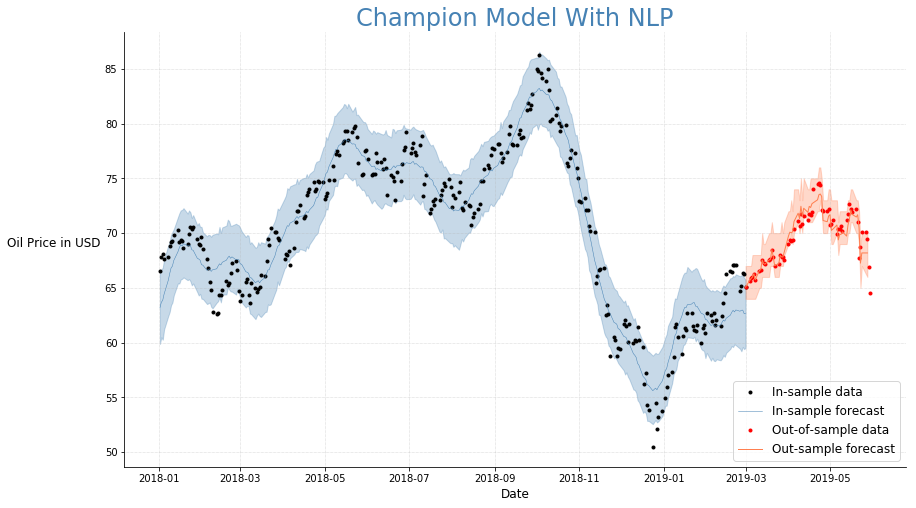

In [654]:
f, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_train.index, y_train.y, 'ko', label='In-sample data', markersize=3)
ax.plot(y_train.index, y_train.yhat, label='In-sample forecast', color='steelblue', lw=0.5)
ax.fill_between(y_train.index, y_train.yhat_lower, y_train.yhat_upper, color='steelblue', alpha=0.3)
test = forecast_nlp_abs.loc['2019-03-01':'2019-05-30']
ax.plot(test.index, test.y, 'ro', label='Out-of-sample data', markersize=3)
ax.plot(df_cumsum.index, df_cumsum.yhat, label='Out-sample forecast', color='coral', lw=1)
ax.fill_between(df_cumsum.index, df_cumsum.yhat_lower_abs, df_cumsum.yhat_upper_abs, color='coral', alpha=0.3)
ax.legend(loc='best')
ax.grid(ls=':', lw=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='lower right', fontsize=12)
plt.title("Champion Model With NLP", color='steelblue', size=24)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Oil Price in USD", fontsize=12,rotation='horizontal',ha='right');

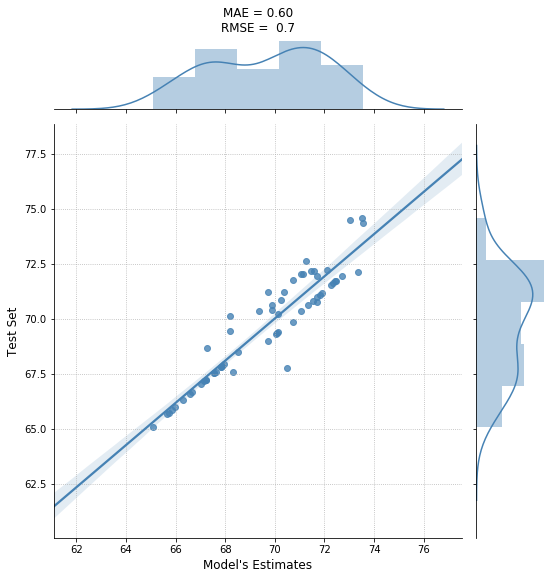

In [626]:
g = sns.jointplot(x='yhat_y', y='y_x', data = df_comb_cumsum, kind="reg", color="steelblue")
g.fig.set_figwidth(8)
g.fig.set_figheight(8)
ax = g.fig.axes[1]
ax.set_title("MAE = {:4.2f}\nRMSE = {:4.1f}".format(MAE(df_comb_cumsum.loc[:,'y_x'].values, df_comb_cumsum.loc[:,'yhat_y'].values), RMSE(df_comb_cumsum.loc[:,'y_x'].values, df_comb_cumsum.loc[:,'yhat_y'].values)), fontsize=12)
ax = g.fig.axes[0]
ax.set_xlabel("Model's Estimates", fontsize=12)
ax.set_ylabel("Test Set", fontsize=12)
ax.grid(ls=':')

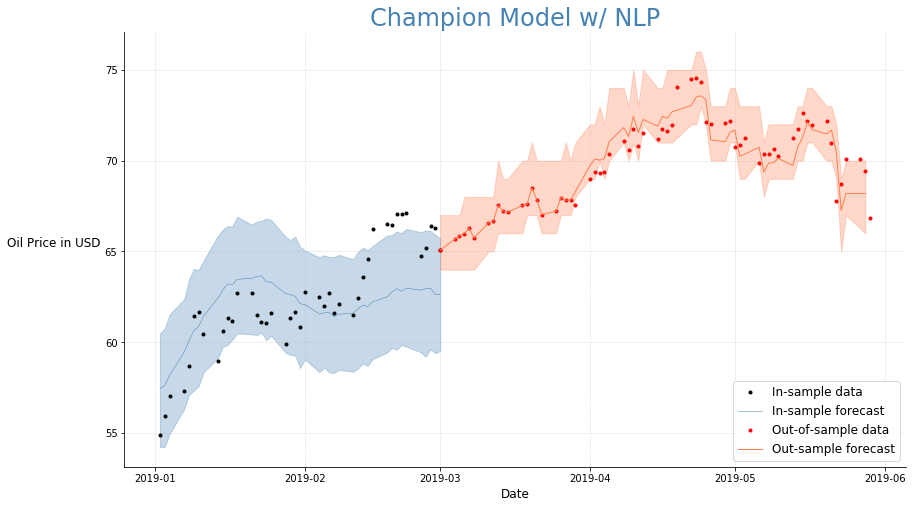

In [653]:
## y_train_short = forecast_nlp_abs.loc['2019-01-01':'2019-03-01']
f, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_train_short.index, y_train_short.y, 'ko', label='In-sample data', markersize=3)
ax.plot(y_train_short.index, y_train_short.yhat, label='In-sample forecast', color='steelblue', lw=0.5)
ax.fill_between(y_train_short.index, y_train_short.yhat_lower, y_train_short.yhat_upper, color='steelblue', alpha=0.3)
test = forecast_nlp_abs.loc['2019-03-01':'2019-05-29']
ax.plot(test.index, test.y, 'ro', label='Out-of-sample data', markersize=3)
ax.plot(df_cumsum.index, df_cumsum.yhat, label='Out-sample forecast', color='coral', lw=1)
ax.fill_between(df_cumsum.index, df_cumsum.yhat_lower_abs, df_cumsum.yhat_upper_abs, color='coral', alpha=0.3)
ax.legend(loc='best')
ax.grid(ls=':', lw=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='lower right', fontsize=12)
plt.title("Champion Model w/ NLP", color='steelblue', size=24)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Oil Price in USD", fontsize=12,rotation='horizontal',ha='right');

##### Cross Validation
 
Next let’s measure the forecast error using the historical data. We’ll do this by comparing the predicted values with the actual values. In order to perform this operation we select cut of points in the history of the data and fit the model with data upto that cut off point. Afterwards we compare the actual values to the predicted values. The cross_validation method allows us to do this in Prophet. This method take the following parameters as explained below:

1. horizon the forecast horizon
2. initial the size of the initial training period
3. period the spacing between cutoff dates

In [192]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='354 days', period='90 days', horizon = '60 days')
df_cv.head()

ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2018-12-31 -1.965161   -4.780619    0.546014  0.59 2018-12-30
1 2019-01-02 -2.357508   -5.433765    0.733019  0.59 2018-12-30
2 2019-01-03 -2.717610   -6.170790    0.536353  1.04 2018-12-30
3 2019-01-04 -2.457312   -6.009483    1.092653  1.11 2018-12-30
4 2019-01-07 -2.312501   -6.080672    1.490677  0.27 2018-12-30

In [193]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon        mse      rmse       mae      mape  coverage
0  5 days  10.515500  3.242761  3.206898  4.038360      0.25
1  8 days  10.550616  3.248171  3.213733  5.346869      0.50
2  9 days  12.617825  3.552158  3.506317  4.838545      0.50
3 10 days  15.744376  3.967918  3.856920  4.409540      0.50
4 11 days  14.768240  3.842947  3.707603  6.699888      0.75

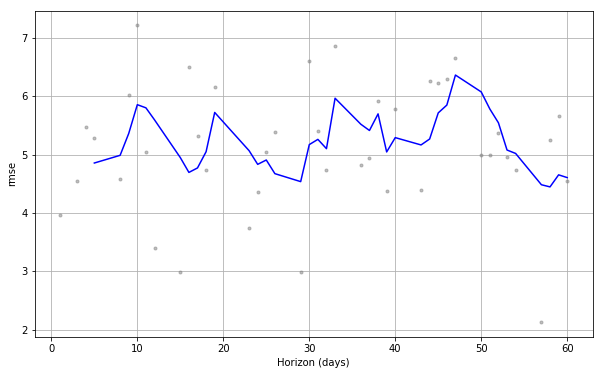

In [233]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

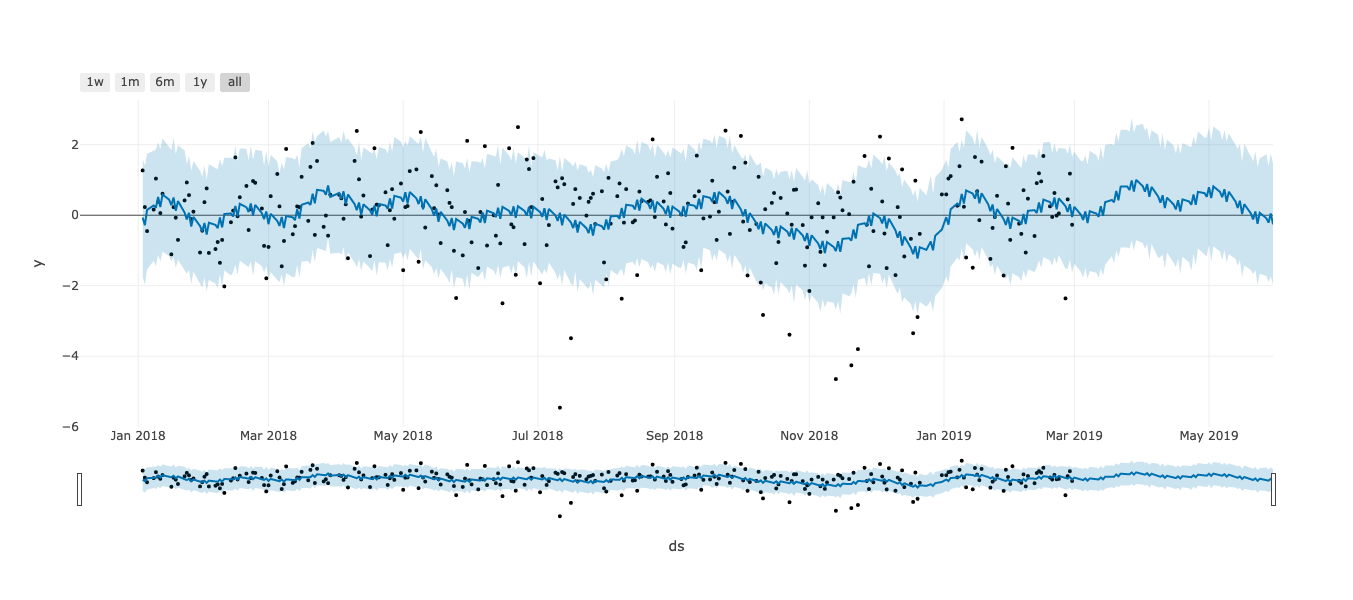

In [234]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)